In [90]:
import pandas as pd
from pandas import read_html
import numpy as np
from google.cloud import bigquery
import os
from google.cloud.bigquery import SchemaField

def get_watches():
    
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/zachquinn/Downloads/ornate-reef-332816-a7425b762ba2.json"
    
    # Numbers 1 - 77
    
    base_url = 'https://en.wikipedia.org/wiki/List_of_most_expensive_watches_sold_at_auction'
    watches = read_html(base_url, attrs={'class': 'wikitable sortable'}, header=1)
    watch_df = pd.DataFrame(watches[0])
    watch_df.rename(columns={'.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}M.Y.': 'Model_Year', 'Watch model': 'Watch_Model',
                             'Inflation-adjusted': 'Inflation_Adjusted',
                        'Auctiondate': 'Auction_Date', 'Auctionplace': 'Auction_Place', 'Auctionhouse': 'Auction_House'}, inplace=True)
    watch_df = watch_df.drop(['Ref.'], axis=1)

    for col in watch_df.columns:
        watch_df['Watch_Model'] = watch_df['Watch_Model'].str.replace('[Note 4]', '')
        watch_df['Watch_Model'] = watch_df['Watch_Model'].str.replace(r'\[.*\]', ' ')
    
    watch_df['Auction_Date'] = pd.to_datetime(watch_df['Auction_Date'])
    
    # Numbers 77 - 113
    
    watch_second_half = watches[1]
    watch_second_half_df = pd.DataFrame(watch_second_half)

    watch_second_half_df.rename(columns={'Watch model': 'Watch_Model', 'M.Y.': 'Model_Year', 'Inflation-adjusted': 'Inflation_Adjusted',
                                 'Auctiondate': 'Auction_Date', 'Auctionplace': 'Auction_Place', 'Auctionhouse': 'Auction_House'}, inplace=True)
    watch_second_half_df = watch_second_half_df.drop(['Ref.'], axis=1)
    
    watch_second_half_df['Auction_Date'] = pd.to_datetime(watch_second_half_df['Auction_Date'])
    
    # Latest Auction Prices
    
    watch_third_url = 'https://en.wikipedia.org/wiki/List_of_most_expensive_watches_sold_at_auction'
    watch_third = pd.read_html(watch_third_url, attrs={'class': 'wikitable sortable'})
    watch_third_df = pd.DataFrame(watch_third[2])
    watch_third_df = watch_third_df.drop(['Adjusted price (USD millions)'], axis=1)
    watch_third_df = watch_third_df.drop(['Ref.'], axis=1)
    watch_third_df.rename(columns={'Watch model': 'Watch_Model', 'M.Y.': 'Model_Year', 'Original price (USD millions)':
                          'Price_USD_Millions', 'Auction date': 'Auction_Date', 'Auction place': 'Auction_Place',
                          'Auction house': 'Auction_House'}, inplace=True)
    
    for col in watch_third_df.columns:
        watch_third_df['Price_USD_Millions'] = watch_third_df['Price_USD_Millions'].str.replace("(without buyer's premium)", '')
        
    for col in watch_third_df.columns:
        watch_third_df['Price_USD_Millions'] = watch_third_df['Price_USD_Millions'].str.replace(r"\(.*\)", '')
    
    for col in watch_third_df.columns:
        watch_third_df['Model_Year'] = watch_third_df['Model_Year'].str.replace(r'\[.*\]', '1951')
        watch_third_df['Model_Year'] = watch_third_df['Model_Year'].str.replace(r"\(.*\)", '')
    
    watch_third_df['Auction_Date'] = pd.to_datetime(watch_third_df['Auction_Date'])
    
    watch_third_df['Price_USD_Millions'] = watch_third_df['Price_USD_Millions'].astype(float)
    
    watch_all = pd.concat([watch_df, watch_second_half_df, watch_third_df], ignore_index=True)
    watch_all = watch_all.sort_values(by=['Manufacturer'], ascending=True).reset_index(drop=True)
    watch_all['Original'] = watch_all['Original'].fillna(0)
    watch_all['Inflation_Adjusted'] = watch_all['Inflation_Adjusted'].fillna(0)
    watch_all['Price_USD_Millions'] = watch_all['Price_USD_Millions'].fillna(0)
    
    watch_all_df = pd.DataFrame(watch_all)
    
    schema = [
        bigquery.SchemaField("Rank", "INTEGER", mode="NULLABLE"),
        bigquery.SchemaField("Manufacturer", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Model_Year", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Style", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Original", "FLOAT", mode="NULLABLE"),
        bigquery.SchemaField("Inflation_Adjusted", "FLOAT", mode="NULLABLE"),
        bigquery.SchemaField("Auction_Date", "TIMESTAMP", mode="NULLABLE"),
        bigquery.SchemaField("Auction_Place", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Auction_House", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Price_USD_Millions", "FLOAT", mode="NULLABLE")
    ]
    
    client = bigquery.Client()
    dataset_id = 'watches'
    table_id = 'auction_prices'
    
    dataset_ref = client.dataset(dataset_id)
    table_id = dataset_ref.table(table_id)
    
    job_config = bigquery.LoadJobConfig()
    job_config.write_disposition='WRITE_TRUNCATE'
    job_config.source_format = bigquery.SourceFormat.CSV
    job_config.schema = schema
    job_config.autodetect=True
    job_config.ignore_unknown_values=True 

    job = client.load_table_from_dataframe(
    watch_all_df,
    table_id,
    location='US',
    job_config=job_config)
    
    job.result()
    
    return print('The auction_prices table has been updated')
    

get_watches()

,Rank,Manufacturer,Watch_Model,Model_Year,Style,Original,Inflation_Adjusted,Auction_Date,Auction_Place,Auction_House,Price_USD_Millions
0,34,Attributed to Piguet & Capt,"Pearl-set Musical, Perfume Flask, and Automato...",1805,Amphora-Form,0.000,0.000,2021-05-22,Hong Kong,Christie's,1.577
1,5,Audemars Piguet,Royal Oak Concept Black Panther[disambiguation...,2021,Wrist,0.000,0.000,2021-04-10,Los Angeles,Audemars Piguet,5.200
2,14,Audemars Piguet,Royal Oak “Jumbo” Extra-Thin Only Watch Ref. 1...,2021,Wrist,0.000,0.000,2021-11-06,Geneva,Christie's,3.399
3,71,Breguet,"King George III Recordon, London, Gold Four Mi...",1808,Pocket,1.979,1.979,2020-07-14,London,Sotheby's,0.000
4,47,Breguet,"Brgu,Paris,.111",1827,Pocket,2.751,3.101,2012-05-14,Geneva,Christie's,0.000
...,...,...,...,...,...,...,...,...,...,...,...
154,41,Urwerk,AmicMasrClck&TianiumWriswach,2018,Wrist,2.900,2.935,2019-12-10,New York,Phillips,0.000
155,46,Vacheron Constantin,KingFuadI.02833,1929,Pocket,2.770,3.670,2005-04-03,Geneva,Antiquorum,0.000
156,84,Vacheron Constantin,James W. Packard Minute Repeater,1918,Pocket,1.763,2.028,2011-06-15,New York,Christie's,0.000
157,105,Vacheron Constantin,Pink Gold Tour de I'lle,2005,Wrist,1.564,2.072,2005-04-03,Geneva,Antiquorum,0.000


In [25]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """

SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  Rank,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`

"""
query_job = client.query(query_string)
watch_table = query_job.to_dataframe()
watch_table

,Auction_Date,Manufacturer,Watch_Model,Model_Year,Style,Original_Price_Millions,Inflation_Adjusted_Millions,Price_USD_Millions,Actual_Price,Rank,Auction_Place,Auction_House
0,2021-04-08,Patek Philippe,Sky Moon Tourbillon Ref. 5002P-001,2004,0,0.00,0.00,1.59,1.59,33,DUB,Christie's
1,2015-10-22,Bulova,David Scott Apollo 15 Chronograph No. 885104/01,1971,0,1.65,1.80,0.00,1.80,96,BOS,RR Auction
2,2021-11-07,F. P. Journe,"Chronomètre à Résonance ""Souscription"" 001/00R",2000,0,0.00,0.00,4.28,4.28,7,GEN,Phillips
3,2021-11-06,F. P. Journe,"Tourbillon Souverain à Remontoir d'Egalité ""So...",1999,0,0.00,0.00,3.88,3.88,10,GEN,Phillips
4,2019-05-12,George Daniels,GrandCmplicain,1987,1,2.39,2.42,0.00,2.42,58,GEN,Phillips
...,...,...,...,...,...,...,...,...,...,...,...,...
154,2012-11-28,Patek Philippe,SarCalibr2000Rf.990/1,2008,1,3.28,3.70,0.00,3.70,34,HON,Christie's
155,2019-11-23,Patek Philippe,"GbbiMilan""HursUnivrslls""Rf.2523",1953,0,8.97,9.08,0.00,9.08,6,HON,Christie's
156,2019-11-23,Patek Philippe,WhiGldRf.6002G,2016,0,2.47,2.50,0.00,2.50,56,HON,Christie's
157,2018-10-03,Patek Philippe,WhiGldRf.6002G,2014,0,2.72,2.80,0.00,2.80,51,HON,Poly Auction


In [3]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """

SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`

"""
query_job = client.query(query_string)
watch_table_clean = query_job.to_dataframe()
watch_table_clean

,Auction_Date,Manufacturer,Watch_Model,Model_Year,Style,Original_Price_Millions,Inflation_Adjusted_Millions,Inflation_Difference,Price_USD_Millions,Actual_Price,Auction_Place,Auction_House
0,2021-04-08,Patek Philippe,Sky Moon Tourbillon Ref. 5002P-001,2004,0,0.00,0.00,0.00,1.59,1.59,DUB,Christie's
1,2015-10-22,Bulova,David Scott Apollo 15 Chronograph No. 885104/01,1971,0,1.65,1.80,0.15,0.00,1.80,BOS,RR Auction
2,2021-11-07,F. P. Journe,"Chronomètre à Résonance ""Souscription"" 001/00R",2000,0,0.00,0.00,0.00,4.28,4.28,GEN,Phillips
3,2021-11-06,F. P. Journe,"Tourbillon Souverain à Remontoir d'Egalité ""So...",1999,0,0.00,0.00,0.00,3.88,3.88,GEN,Phillips
4,2019-05-12,George Daniels,GrandCmplicain,1987,1,2.39,2.42,0.03,0.00,2.42,GEN,Phillips
...,...,...,...,...,...,...,...,...,...,...,...,...
154,2012-11-28,Patek Philippe,SarCalibr2000Rf.990/1,2008,1,3.28,3.70,0.42,0.00,3.70,HON,Christie's
155,2019-11-23,Patek Philippe,"GbbiMilan""HursUnivrslls""Rf.2523",1953,0,8.97,9.08,0.11,0.00,9.08,HON,Christie's
156,2019-11-23,Patek Philippe,WhiGldRf.6002G,2016,0,2.47,2.50,0.03,0.00,2.50,HON,Christie's
157,2018-10-03,Patek Philippe,WhiGldRf.6002G,2014,0,2.72,2.80,0.08,0.00,2.80,HON,Poly Auction


In [4]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  SELECT Auction_City, COUNT(1) AS Auction_City_Count 
  FROM clean_tab
  GROUP BY 1 
  ORDER BY Auction_City_Count DESC

"""
query_job = client.query(query_string)
watch_table = query_job.to_dataframe()
watch_table

,Auction_City,Auction_City_Count
0,GEN,107
1,HON,24
2,NEW,18
3,LON,5
4,MON,2
5,DUB,1
6,BOS,1
7,LOS,1


In [5]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  SELECT Auction_House, COUNT(1) AS Auction_House_Count 
  FROM clean_tab
  GROUP BY 1 
  ORDER BY Auction_House_Count DESC

"""
query_job = client.query(query_string)
watch_table = query_job.to_dataframe()
watch_table

,Auction_House,Auction_House_Count
0,Phillips,61
1,Christie's,57
2,Sotheby's,19
3,Antiquorum,18
4,RR Auction,1
5,Phillips (Bacs & Russo),1
6,Poly Auction,1
7,Audemars Piguet,1


In [6]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  SELECT Manufacturer, COUNT(1) AS Manufacturer_Count 
  FROM clean_tab
  GROUP BY 1 
  ORDER BY Manufacturer_Count DESC

"""
query_job = client.query(query_string)
watch_table = query_job.to_dataframe()
watch_table

,Manufacturer,Manufacturer_Count
0,Patek Philippe,107
1,Rolex,19
2,F. P. Journe,4
3,George Daniels,4
4,Philippe Dufour,4
5,Breguet,4
6,Richard Mille,3
7,Vacheron Constantin,3
8,Omega,2
9,Audemars Piguet,2


In [69]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  SELECT Model_Year, COUNT(1) AS Model_Year_Count 
  FROM clean_tab
  GROUP BY 1 
  ORDER BY Model_Year_Count DESC
  LIMIT 20

"""
query_job = client.query(query_string)
model_year = query_job.to_dataframe()
model_year

,Model_Year,Model_Year_Count
0,1953,12
1,1952,8
2,1954,7
3,1951,6
4,2021,6
5,1969,5
6,1971,5
7,1957,5
8,1946,4
9,1939,4


In [82]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  SELECT 
  CASE 
      WHEN Style = 0 THEN 'Wrist Watch'
      ELSE 'Pocket Watch' END AS Style,
  COUNT(1) AS Style_Count 
  FROM clean_tab
  GROUP BY 1 
  ORDER BY Style_Count DESC

"""
query_job = client.query(query_string)
wrist_pocket = query_job.to_dataframe()
wrist_pocket

,Style,Style_Count
0,Wrist Watch,134
1,Pocket Watch,25


In [9]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT AVG(Inflation_Difference) AS Total_Avg_Inflation_Difference
FROM clean_tab 

"""
query_job = client.query(query_string)
watch_table_clean = query_job.to_dataframe()
watch_table_clean

,Total_Avg_Inflation_Difference
0,0.265472


In [11]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT ROUND(AVG(Actual_Price),2) AS Total_Avg_Price_Millions
FROM clean_tab 

"""

query_job = client.query(query_string)
watch_table_clean = query_job.to_dataframe()
watch_table_clean

,Total_Avg_Price_Millions
0,3.64


In [61]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT Auction_House, SUM(Actual_Price) AS Total_Price_Millions
FROM clean_tab 
GROUP BY Auction_House
ORDER BY Total_Price_Millions DESC

"""

query_job = client.query(query_string)
auction_house_millions = query_job.to_dataframe()
auction_house_millions

,Auction_House,Total_Price_Millions
0,Phillips,218.85
1,Christie's,201.66
2,Sotheby's,82.44
3,Antiquorum,59.88
4,Phillips (Bacs & Russo),6.50
5,Audemars Piguet,5.20
6,Poly Auction,2.80
7,RR Auction,1.80


In [57]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT Auction_Place, SUM(Actual_Price) AS Total_Price_Millions
FROM clean_tab 
GROUP BY Auction_Place
ORDER BY Total_Price_Millions DESC

"""

query_job = client.query(query_string)
auction_place_millions = query_job.to_dataframe()
auction_place_millions

,Auction_Place,Total_Price_Millions
0,GEN,402.77
1,NEW,78.93
2,HON,66.73
3,LON,15.48
4,MON,6.63
5,LOS,5.20
6,BOS,1.80
7,DUB,1.59


In [51]:
from google.cloud import bigquery
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT Auction_Year, COUNT(1) AS Auction_Year_Count
FROM
(
SELECT EXTRACT(YEAR FROM Auction_Date) AS Auction_Year
FROM clean_tab 
)
GROUP BY 1 
ORDER BY Auction_Year_Count DESC

"""

query_job = client.query(query_string)
auction_number = query_job.to_dataframe()
auction_number

,Auction_Year,Auction_Year_Count
0,2021,37
1,2019,17
2,2020,12
3,2017,12
4,2018,11
5,2012,8
6,2015,7
7,2016,7
8,2011,7
9,2008,5


In [38]:
from google.cloud import bigquery

client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT * EXCEPT(row_num)
FROM(
SELECT Manufacturer, MAX(Actual_Price) AS Actual_Price_Millions, ROW_NUMBER() OVER(PARTITION BY Manufacturer) AS row_num
FROM clean_tab
GROUP BY 1
)
WHERE row_num = 1
ORDER BY Actual_Price_Millions DESC

"""

query_job = client.query(query_string)
manufacturer_millions = query_job.to_dataframe()
manufacturer_millions

,Manufacturer,Actual_Price_Millions
0,Patek Philippe,31.58
1,Rolex,18.74
2,Breguet,5.28
3,Philippe Dufour,5.21
4,Audemars Piguet,5.20
5,F. P. Journe,4.93
6,George Daniels,4.62
7,Vacheron Constantin,3.67
8,Omega,3.42
9,Urwerk,2.94


In [39]:
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT SUM(Actual_Price) AS Actual_Price_Millions
FROM clean_tab

"""

query_job = client.query(query_string)
sum_millions = query_job.to_dataframe()
sum_millions

,Actual_Price_Millions
0,579.13


In [ ]:
client = bigquery.Client()
query_string = """
WITH clean_tab AS (
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Inflation_Adjusted - Original, 2) AS Inflation_Difference,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_Place,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )

SELECT SUM(Actual_Price) AS Actual_Price_Millions
FROM clean_tab
WHERE Auction

"""

query_job = client.query(query_string)
sum_millions = query_job.to_dataframe()
sum_millions

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

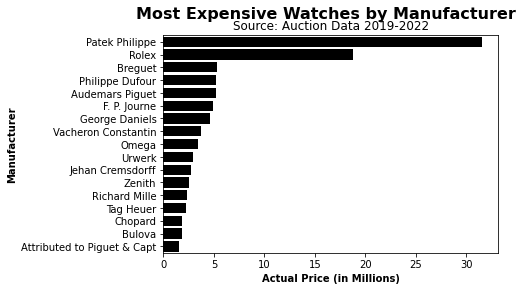

In [77]:
plt.suptitle('Most Expensive Watches by Manufacturer', color = 'black', weight = 'bold').set_fontsize(16)
plt.title('Source: Auction Data 2019-2022').set_fontsize(12)
plot = sns.barplot(x = 'Actual_Price_Millions', y = 'Manufacturer', data = manufacturer_millions, color = 'black')
plt.xlabel('Actual Price (in Millions)', color = 'black', weight = 'bold')
plt.ylabel('Manufacturer', color = 'black', weight = 'bold')
plt.savefig('most_expensive_watch.jpg', bbox_inches='tight', dpi=200)

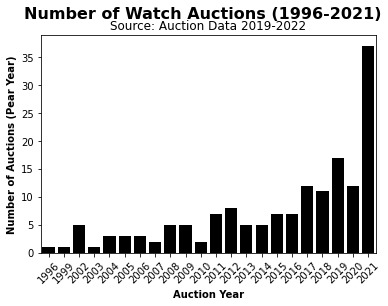

In [81]:
plt.suptitle('Number of Watch Auctions (1996-2021)', color = 'black', weight = 'bold').set_fontsize(16)
plt.title('Source: Auction Data 2019-2022').set_fontsize(12)
plot = sns.barplot(x = 'Auction_Year', y = 'Auction_Year_Count', data = auction_number, color = 'black')
plt.xlabel('Auction Year', color = 'black', weight = 'bold')
plt.xticks(color = 'black', rotation=45)
plt.ylabel('Number of Auctions (Pear Year)', color = 'black', weight = 'bold')
plt.savefig('number_of_auctions.jpg', bbox_inches='tight', dpi=200)

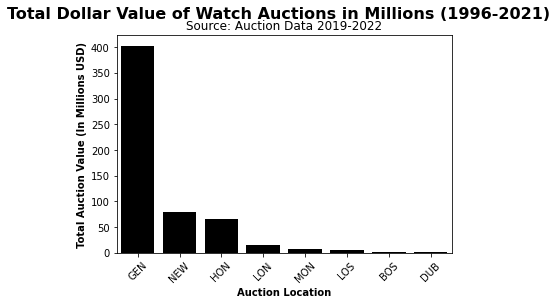

In [76]:
plt.suptitle('Total Dollar Value of Watch Auctions in Millions (1996-2021)', color = 'black', weight = 'bold').set_fontsize(16)
plt.title('Source: Auction Data 2019-2022').set_fontsize(12)
plot = sns.barplot(x = 'Auction_Place', y = 'Total_Price_Millions', data = auction_place_millions, color = 'black')
plt.xlabel('Auction Location', color = 'black', weight = 'bold')
plt.xticks(color = 'black', rotation=45)
plt.ylabel('Total Auction Value (In Millions USD)', color = 'black', weight = 'bold')
plt.savefig('watch_auctions.jpg', bbox_inches='tight', dpi=200)

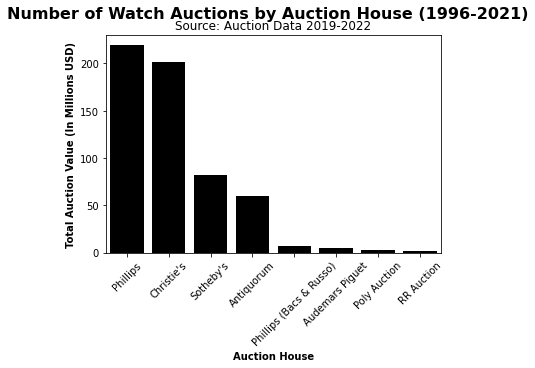

In [80]:
plt.suptitle('Number of Watch Auctions by Auction House (1996-2021)', color = 'black', weight = 'bold').set_fontsize(16)
plt.title('Source: Auction Data 2019-2022').set_fontsize(12)
plot = sns.barplot(x = 'Auction_House', y = 'Total_Price_Millions', data = auction_house_millions, color = 'black')
plt.xlabel('Auction House', color = 'black', weight = 'bold')
plt.xticks(color = 'black', rotation=45)
plt.ylabel('Total Auction Value (In Millions USD)', color = 'black', weight = 'bold')
plt.savefig('auction_houses.jpg', bbox_inches='tight', dpi=200)

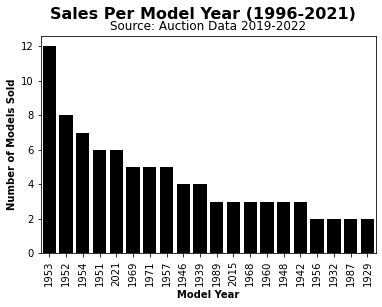

In [79]:
plt.suptitle('Sales Per Model Year (1996-2021)', color = 'black', weight = 'bold').set_fontsize(16)
plt.title('Source: Auction Data 2019-2022').set_fontsize(12)
plot = sns.barplot(x = 'Model_Year', y = 'Model_Year_Count', data = model_year, color = 'black')
plt.xlabel('Model Year', color = 'black', weight = 'bold')
plt.xticks(color = 'black', rotation=90)
plt.ylabel('Number of Models Sold', color = 'black', weight = 'bold')
plt.savefig('model_year.jpg', bbox_inches='tight', dpi=200)

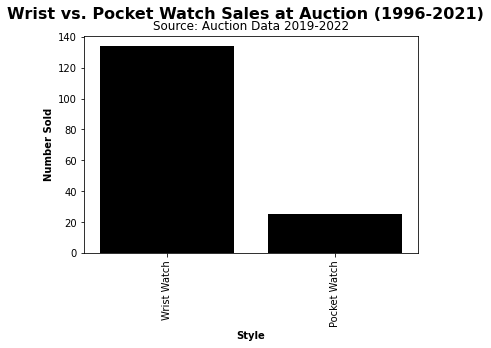

In [84]:
plt.suptitle('Wrist vs. Pocket Watch Sales at Auction (1996-2021)', color = 'black', weight = 'bold').set_fontsize(16)
plt.title('Source: Auction Data 2019-2022').set_fontsize(12)
plot = sns.barplot(x = 'Style', y = 'Style_Count', data = wrist_pocket, color = 'black')
plt.xlabel('Style', color = 'black', weight = 'bold')
plt.xticks(color = 'black', rotation=90)
plt.ylabel('Number Sold', color = 'black', weight = 'bold')
plt.savefig('wrist_pocket.jpg', bbox_inches='tight', dpi=200)

In [88]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  
  SELECT SUM(Actual_Price) AS Total_Price_Millions
  FROM(
  SELECT 
  CASE 
      WHEN Style = 0 THEN 'Wrist Watch'
      ELSE 'Pocket Watch' END AS Style,
    Actual_Price
    FROM clean_tab
  )
  WHERE Style = 'Pocket Watch'

"""
query_job = client.query(query_string)
wrist_pocket_sales = query_job.to_dataframe()
wrist_pocket_sales

,Total_Price_Millions
0,103.07


In [89]:
client = bigquery.Client()
query_string = """

WITH clean_tab AS(
SELECT
  EXTRACT(DATE
  FROM
    Auction_Date) AS Auction_Date,
  Manufacturer,
  Watch_Model,
  Model_Year,
  CASE
    WHEN Style = 'Wrist' THEN 0
  ELSE
  1
END
  AS Style,
  ROUND(Original, 2) AS Original_Price_Millions,
  ROUND(Inflation_Adjusted, 2) AS Inflation_Adjusted_Millions,
  ROUND(Price_USD_Millions, 2) AS Price_USD_Millions,
  ROUND(GREATEST(Inflation_Adjusted, Price_USD_Millions, Original),2) AS Actual_Price,
  UPPER(LEFT(Auction_Place, 3)) AS Auction_City,
  Auction_House
FROM
  `ornate-reef-332816.watches.auction_prices`
  )
  
  SELECT AVG(Inflation_Adjusted_Millions) AS Avg_Inflation_Millions
  FROM clean_tab

"""
query_job = client.query(query_string)
wrist_pocket_sales = query_job.to_dataframe()
wrist_pocket_sales

,Avg_Inflation_Millions
0,2.921635
